# Import the appropriate libraries

In [19]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers, Sequential
import time

# Import Training and Testing datasets

In [20]:
train_dir = '/home/cslab010/Ai_ML_Projects/AUEB_Ai_ResNet50_/ImageDATA/train_data_2'
test_dir = '/home/cslab010/Ai_ML_Projects/AUEB_Ai_ResNet50_/ImageDATA/test_data_2'

# Image Data pre-processing -- Data Augmentation and Normalization

In [21]:
# Since the dataset is folder-structured, set the parameteres to load data from directory and set their parameters

# Set the image resolution
img_size = (224, 224)

# Set the batch size number
batch_size = 32

# Train 100% Dataset creation
train_generator = image_dataset_from_directory(
    train_dir,
    image_size = img_size,
    batch_size = batch_size,

    # Label mode for classification purposes
    label_mode = 'categorical',
    shuffle = True
)

# Test dataset creation
test_generator = image_dataset_from_directory(
    test_dir,
    image_size = img_size,
    batch_size = batch_size,
    label_mode = 'categorical',
    shuffle = False # do not shuffle data!
)

Found 382 files belonging to 4 classes.
Found 48 files belonging to 4 classes.


In [22]:
# Data augmentation: Random flips, rotations, zooms, etc.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [24]:
# Normalize the images to [0, 1] range (as required for pre-trained models)
normalization = tf.keras.layers.Rescaling(1./255)


# Apply both data augmentation and normalization to the Train dataset
def preprocess_train(image, label):
    
    # Apply data augmentation (during training)
    image = data_augmentation(image)

    # Normalize the image to [0, 1] range
    image = normalization(image)

    return image, label

# Map the preprocessing function to the dataset
train_dataset = train_generator.map(preprocess_train)


# Normalize Validation data, as well
def preprocess_val_test(image, label):
    
    # Normalize the image to [0, 1] range
    image = normalization(image)

    return image, label

# Normalize Test data
test_dataset = test_generator.map(preprocess_val_test)


# Input image shape
images, labels = next(iter(train_dataset))
print("Image shape: ", images.shape, labels.shape)

Image shape:  (32, 224, 224, 3) (32, 4)


2024-09-29 18:57:13.866793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 4390990767474453422
2024-09-29 18:57:13.866912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3711842341672062989
2024-09-29 18:57:13.866936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11365122559323144947
2024-09-29 18:57:13.866944: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2628509191253882131
2024-09-29 18:57:13.866954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9329776913613078061
2024-09-29 18:57:13.866961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12655467235804643115


# Training Image Examples

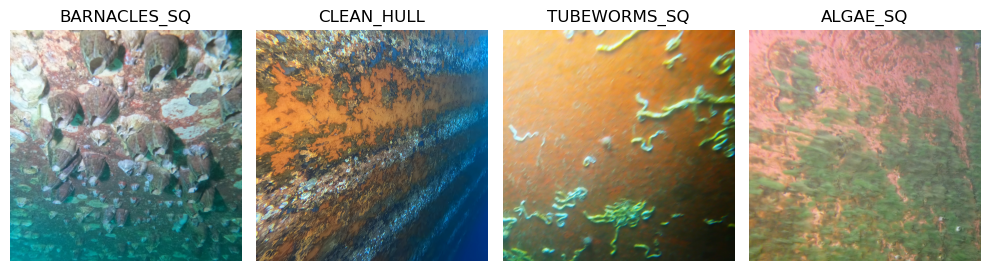

In [25]:
# Return α list with the class names within the folder-structure data directory
ClassNames_LIST = os.listdir(train_dir)

# Plot initialization
plt.figure(figsize=(10, 10))

# Loop through the folder-structure  directory and plot the first image of each class subfolder
for index, ClassName in enumerate(ClassNames_LIST):

    # Get the corresponding class sub-directory
    Class_subDIR = os.path.join(train_dir, ClassName)

    # Execute if the path is a directory
    if os.path.isdir(Class_subDIR):
        
        # Get the first image file from the corresponding class sub-directory
        ImageFile = os.listdir(Class_subDIR)[0]

        # Get the path of the first image
        ImagePath = os.path.join(Class_subDIR, ImageFile)
        
        # Image Ploting
        Image = mpimg.imread(ImagePath)
        plt.subplot(1, len(ClassNames_LIST), index + 1)
        plt.imshow(Image)
        plt.title(ClassName)
        plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

# Load ResNet50 pre-trained image classification model

In [26]:
# Load the ResNet50 Pre-trained model
ResNet_Model = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

# Freeze the pre-trained layers
ResNet_Model.trainable = False

# Define functions for Model execution according to the number of epochs

In [40]:
# Define function for new Model creation using ResNet50 pretrained model as base model
def new_MODEL():
    
    # Create sequential model
    model = Sequential()
    
    # Add the pretrained ResNet50 model layers to model
    model.add(ResNet_Model)
    
    # Add fully connected layers for classification
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(4, activation = 'softmax'))

    return model

# ----------------------------------------------------------------------------------------------------

# Define function for Model execution
def exec_Model(epchs, train_dataset, test_dataset):

    accu_list = []
    for times in range(5):
        
        # Create a new sequential model
        model_0 = new_MODEL()
        
        # Model compilation passing the appropriate paramaterers
        model_0.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        
        # Set the the training datataset batch size and the number of epochs
        bs = 32
        n_epochs = epchs

        # Train the model while tracking the training progress
        model_0.fit(train_dataset, epochs = n_epochs, verbose = 0, batch_size = bs)

        # Model evaluation on unseen Test dataset
        test_loss, test_acc = model_0.evaluate(test_dataset)

        accu_list.append(test_acc) # append model accuracy in the list

    return accu_list

# ----------------------------------------------------------------------------------------------------

# Define function for trial model executions for the corresponding number of epochs
def trial_exec_Models(eps, tr_data, ts_data):
    
    # Start Time
    start_time = time.time()

    # Call 'exec_Model()' function
    accList = exec_Model(eps, tr_data, ts_data)

    print("EPOCHS: ", eps)
    print("Accuracy vector: ", [round(elem, 2) for elem in accList])
    print("Mean accuracy: ", round(np.mean(accList), 2))
    
    # End Time
    end_time = time.time()
    
    # Print the execution Time
    execution_time = round((end_time - start_time), 2)
    print(f"Execution Time: {execution_time:.5f} seconds")

# 10 Epochs trial 

In [41]:
trial_exec_Models(10, train_dataset, test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 736ms/step - accuracy: 0.4514 - loss: 1.1270
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 682ms/step - accuracy: 0.4444 - loss: 1.2587
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 687ms/step - accuracy: 0.4931 - loss: 1.1414
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.6285 - loss: 1.3894
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 803ms/step - accuracy: 0.5556 - loss: 1.0244
EPOCHS:  10
Accuracy vector:  [0.4, 0.42, 0.46, 0.65, 0.58]
Mean accuracy:  0.5
Execution Time: 126.43000 seconds


# 20 Epochs trial

In [45]:
trial_exec_Models(20, train_dataset, test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 688ms/step - accuracy: 0.6910 - loss: 1.1715
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step - accuracy: 0.4583 - loss: 1.2274
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 709ms/step - accuracy: 0.5556 - loss: 1.3419
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 692ms/step - accuracy: 0.4792 - loss: 1.3751
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 695ms/step - accuracy: 0.5521 - loss: 1.0319
EPOCHS:  20
Accuracy vector:  [0.71, 0.44, 0.58, 0.5, 0.56]
Mean accuracy:  0.56
Execution Time: 218.78000 seconds


# 35 Epochs trial

In [43]:
trial_exec_Models(35, train_dataset, test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 707ms/step - accuracy: 0.6250 - loss: 1.1617
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 726ms/step - accuracy: 0.6319 - loss: 0.9274
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 685ms/step - accuracy: 0.5938 - loss: 0.9987
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 751ms/step - accuracy: 0.5069 - loss: 1.5248
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 703ms/step - accuracy: 0.5417 - loss: 1.7203
EPOCHS:  35
Accuracy vector:  [0.62, 0.67, 0.62, 0.54, 0.56]
Mean accuracy:  0.6
Execution Time: 355.68000 seconds


# 50 Epochs trial

In [44]:
trial_exec_Models(50, train_dataset, test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 684ms/step - accuracy: 0.5556 - loss: 1.1256
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 709ms/step - accuracy: 0.6424 - loss: 1.2974
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 688ms/step - accuracy: 0.6319 - loss: 1.0331
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 675ms/step - accuracy: 0.6181 - loss: 1.1617
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 688ms/step - accuracy: 0.5417 - loss: 1.3562
EPOCHS:  50
Accuracy vector:  [0.58, 0.67, 0.67, 0.65, 0.56]
Mean accuracy:  0.62
Execution Time: 488.10000 seconds


# 100 Epochs Trial

In [47]:
trial_exec_Models(100, train_dataset, test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 691ms/step - accuracy: 0.6181 - loss: 1.1687
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 727ms/step - accuracy: 0.6424 - loss: 1.0120
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 702ms/step - accuracy: 0.5347 - loss: 1.2945
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 677ms/step - accuracy: 0.5833 - loss: 1.4293
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 683ms/step - accuracy: 0.6076 - loss: 1.1764
EPOCHS:  100
Accuracy vector:  [0.65, 0.67, 0.58, 0.62, 0.65]
Mean accuracy:  0.63
Execution Time: 953.78000 seconds
